<a href="https://colab.research.google.com/github/lucasfldmn/twrds_unbiased_anns/blob/main/comprehensive_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook accompanies the thesis "Towards Unbiased Neural Networks from Biased Training Data". We provide a fully functional implementation of the most important findings in order to replicate them within this notebook in the spirit of open science. 

As the structure of this notebook mirrors that of the thesis we encourage the reader to jump back-and-forth for a more detailed or a moore implementation-focussed perspective.

Note that this notebook is **not** a complete TL;DR of the thesis as we will skip the theoretical background and disregard bias in classification settings completely. We will also not provide references within this notebook as you can find them in the related chapter in the thesis.

Now, let's start by framing the problem: Artifical intelligence (AI) and machine learning (ML) are taking the world by storm and they are increasingly employed in high-stakes tasks such as disease detection or credit scoring. 

In recent years, many machine learning applications have shown discrimination against subgroups of the population with minorities being affected more frequently. Examples of such "machine bias" span from large tech companies to small groups of researchers with severe consequences. For example, a black man was wronfully accused of a crime based on erroneous but confident security video footage analysis using machine learning.

A lot of research on preventing machine bias focuses on measuring and removing bias from popular training data sets. This is not enough for a practical setting where training data is often proprietary and no system of checks and balances is in place to measure let alone prevent discrimination.

We aim to create a minimal working example of a convolutional neural network (CNN) that is robust against bias in the training data. To enable this, we create a framework using artificial training images that allows us to investigate more closely how features of biased training data affect learning of discrimination.

# Preparations

While you ponder the wide-reaching implications that machine bias can have on modern society, let us set up the colab environment by importing all necessary packages as well as additional functions.

First of all, if you are running this notebook in a virtual Google Colaboratory environment (which we recommend to save time setting up a local environment), please set the hardware accelaration to "GPU". Training of larger CNNs is just faster this way. [This tutorial](https://www.geeksforgeeks.org/how-to-use-google-colab/) shows you how to set the runtime type.

## Package Upgrades

This makes for a nicer progress bar.

In [ ]:
!pip install tqdm --upgrade

     |████████████████████████████████| 81kB 5.7MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


## Imports

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Layer, Conv2D, MaxPool2D, Flatten, Dense
from keras.utils.vis_utils import plot_model

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from IPython.display import Javascript

# Plotting
import matplotlib.pyplot as plt

# Statistics
from scipy.stats import norm, ks_2samp

# Other
import itertools
from tqdm.contrib.itertools import product as tqdm_product

## GitHub Integration

We need to clone our git repository in order to access functions for training data generation and model evaluation.

In [ ]:
!rm -rf twrds_unbiased_anns
!git clone https://github.com/lucasfldmn/twrds_unbiased_anns/ -q

## Functions

Now we can import all the functions we need.

In [ ]:
# Sample creation
from twrds_unbiased_anns.src.data.samples import create_sample_array, get_sample_data, get_sample_params, convert_sample_to_np_array, gen_from_sample, dataset_from_gen
# Evaluation
from twrds_unbiased_anns.src.data.eval import load_eval_samples, evaluate_performance, evaluate_model, store_results

## Interaction

Some more settings for our interactive output cells.

In [ ]:
# Allow for larger output cells
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Set button layout
button_layout = Layout(width='180px', height='30px')

# Set slider config
slider_total_width = '800px'
slider_desc_width = '200px'

<IPython.core.display.Javascript object>

# Experimental Setup

## Training Data

In this section we will explore the training data used for our tasks.

First, we will have a look at the sample array and the resulting sample images that we will use to train our model. Our sample contains multiple noisy images of two different types of shapes (square and circle) in two different colors (white and red). We can see color as a proxy for ethnicity and the shape type as a proxy for sex or gender.

The shape size varies per image and corresponds to the target variable that we aim to predict in our model. The exemplary shapes have a size of 150 (left) and 20 (right).

![White Square](https://github.com/lucasfldmn/twrds_unbiased_anns/raw/main/figures/shapes/white_square_150_noisy.png) | ![Red Circle](https://github.com/lucasfldmn/twrds_unbiased_anns/raw/main/figures/shapes/red_circle_20_noisy.png)

For each combination of the two shape attributes, we set its share, mean $\mu$, and standard deviation $\sigma$ in the training data. In this step we can introduce bias by varying the parameters across different attributes. 

For example, the configuration below is biased against red shapes because their average size is half of the size of white shapes. Additionally, the size of red shapes exhibits less variance than the white shapes. The sample contains 25% each of white squares, white circles, red squares, and red circles.

In [ ]:
white_square = [25, 100, 20] # share, mean, stddev
white_circle = [25, 100, 20]
colorful_square = [25, 50, 3]
colorful_circle = [25, 50, 3]

We now generate a sample array that contains the shape attributes and the target variable sampled from a distribution based on the matching parameters. 
The first column encodes the shape color (1 = white), the second column denotes the shape type (1 = square), and the third column contains the shape size.

This leightweight format allows us to construct the training images and targets but requires much less disk space when saving samples for later use.

In [ ]:
# Set size of training data
dataset_size = 400

# Prepare sample
train_sample = create_sample_array(dataset_size, white_square, white_circle, colorful_square, colorful_circle)
train_df = pd.DataFrame(train_sample)
train_df.columns = ["iswhite", "issquare", "size"]
train_df

,iswhite,issquare,size
0,1.0,1.0,118.0
1,0.0,0.0,49.0
2,0.0,1.0,50.0
3,1.0,1.0,72.0
4,1.0,1.0,74.0
...,...,...,...
395,0.0,1.0,52.0
396,0.0,0.0,51.0
397,1.0,0.0,116.0
398,0.0,0.0,54.0


Let's also plot the distribution of red vs. white shapes to see the impact of our parameter choice.

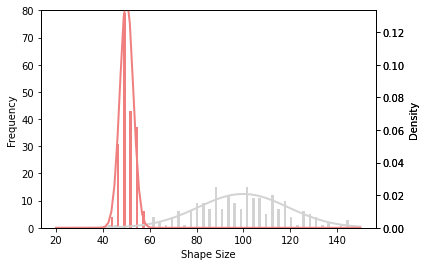

In [ ]:
def plot_training_sample(df):
  # Plot parameters
  bins = 40
  color_white = "lightgrey"
  color_colorful = "lightcoral"
  colors = [color_white, color_colorful]

  fig = plt.plot(figsize=(20,10))
  ax = plt.gca()
  actual_white = df[df['iswhite'] == 1.0]["size"]
  actual_color = df[df['iswhite'] == 0.0]["size"]
  data = [actual_white, actual_color]
  ax.hist(data, color = colors, bins = bins, label = ["White Shapes", "Colorful Shapes"])
  ax.set_ylim(0,80)
  ax.set_ylabel('Frequency')
  ax.set_xlabel('Shape Size')
  for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 20, 150
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    # Set limit of secondary axis based on frequency and total sample size 
    ax2.set_ylim([0, ax.get_ylim()[1] / (df.size/2)])
    ax2.set_ylabel('Density')

  # Show plot
  plt.show()

plot_training_sample(train_df)

As we can see, the distribution of shape size differs based on the shape color based on the parameters we chose.

## Evaluation Data

Similar to the training data, we also define an evaluation sample that does not contain any bias. We use the exact same values of shape size per attribute combination with a mean $\mu$ of 100 and a standard deviation $\sigma$ of 20. The evaluation sample contains 125 images for each of the four attribute combinations.

We save this evaluation sample and employ it for the evaluation of each model to see whether or not it has learned bias from the training data. If a model systematically favors one group over the other during the evaluation this indicates that it learned bias from its training data.

In [ ]:
eval_sample_filename = "/content/twrds_unbiased_anns/data/eval/eval_500_mean_100_std_20.data"

eval_sample = load_eval_samples(eval_sample_filename)
df_eval_raw = pd.DataFrame(eval_sample)
df_eval = pd.DataFrame(df_eval_raw[0][0])
df_eval = df_eval.append(pd.DataFrame(df_eval_raw[0][1]))
df_eval = df_eval.append(pd.DataFrame(df_eval_raw[0][2]))
df_eval = df_eval.append(pd.DataFrame(df_eval_raw[0][3]))
df_eval.columns = ["is_white", "is_square", "shape_size"]
df_eval

,is_white,is_square,shape_size
0,1.0,1.0,115.0
1,1.0,1.0,127.0
2,1.0,1.0,113.0
3,1.0,1.0,107.0
4,1.0,1.0,92.0
...,...,...,...
120,0.0,0.0,77.0
121,0.0,0.0,84.0
122,0.0,0.0,102.0
123,0.0,0.0,108.0


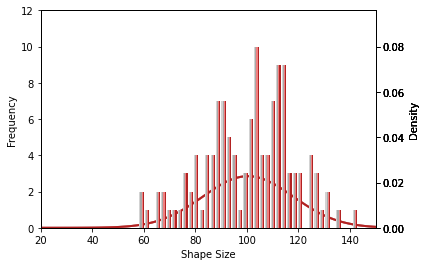

In [ ]:
# Plot parameters
labels = ["White Shapes", "Red Shapes"]
bins = 40
color_white_square = "lightgrey"
color_white_circle = "darkgrey"
color_colorful_square = "lightcoral"
color_colorful_circle = "firebrick"
colors = [color_white_square, color_white_circle, color_colorful_square, color_colorful_circle]

# Plot results  
fig = plt.plot(figsize=(20,10))
ax = plt.gca()
w = df_eval[df_eval['is_white'] == 1.0]
r = df_eval[df_eval['is_white'] == 0.0]
actual_ws = w[w['is_square'] == 1.0].shape_size	
actual_wc = w[w['is_square'] == 0.0].shape_size
actual_rs = r[r['is_square'] == 1.0].shape_size	
actual_rc = r[r['is_square'] == 0.0].shape_size
data = [actual_ws, actual_wc, actual_rs, actual_rc]
ax.set_xlim(20,150)
ax.set_ylim(0,12)   
ax.hist(data, color = colors, bins = bins, label = labels)
ax.set_ylabel('Frequency')  
ax.set_xlabel('Shape Size')
for cat_data, color in zip(data, colors):
  # Fit a normal distribution to the data
  mu, std = norm.fit(cat_data)
  # Calculate PDF
  xmin, xmax = 20, 150
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)
  # Plot PDF
  ax2 = ax.twinx()
  ax2.plot(x, p, color = color, linewidth = 2)
  # Calcualte ylim of second axis based on first axis      
  ylim_max_1 = ax.get_ylim()[1]
  ylim_max_2 = ylim_max_1 / (df_eval.shape_size.size/4)
  ax2.set_ylim([0, ylim_max_2])
  ax2.set_ylabel('Density')
# Fix plot display order
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
# Show plot
plt.show()  

We can see no difference between different colors or shape types in the evaluation sample. Differences in a model's prediction are purely based on learned bias from the training data.

## CNN Architecture

We use a simple convolutional neural network (CNN) to predict the shape size. Our CNN contains three convolutional layers with maximum pooling in between followed by three fully connected layers to funnel the flattened feature maps into a single value. 

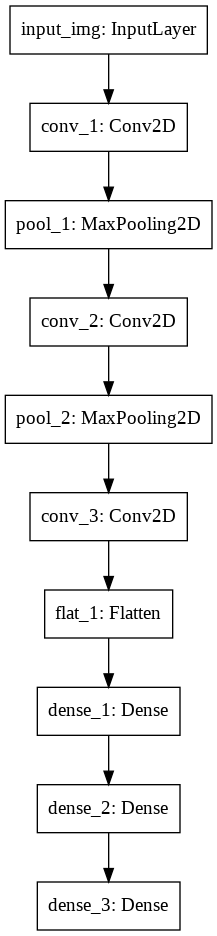

In [ ]:
def make_cnn_model():
  model_input = Input(shape=(360, 360, 3), name="input_img")
  x = Conv2D(16, (3, 3), padding = "same", activation = "relu", name = "conv_1")(model_input)
  x = MaxPool2D(pool_size = (4, 4), name = "pool_1")(x)
  x = Conv2D(32, (3, 3), padding = "same", activation = "relu", name = "conv_2")(x)
  x = MaxPool2D(pool_size = (4, 4), name = "pool_2")(x)
  x = Conv2D(32, (3, 3), padding = "same", activation = "relu", name = "conv_3")(x)
  x = Flatten(name = "flat_1")(x)
  x = Dense(100, activation="relu", name = "dense_1")(x)
  x = Dense(20, activation="relu", name = "dense_2")(x)
  model_output = Dense(1, name = "dense_3")(x)
  return tf.keras.Model(model_input, model_output, name = "Base_CNN")

# Plot the model
plot_model(make_cnn_model())

# Discrimination in Regression Tasks

In this section we will evaluate how different features of the training data affect machine bias. For this, we will first take another look at the training data to develop hypotheses before putting them to a test experimentally.

## Discrimination Metrics

We devise three metrics to identify and measure discrimination in a regression setting using our artificial training and evaluation data:
*   **Difference in Prediction Distribution**: Since we know that the distribution of actual shape sizes in our evaluation is the exact same across all groups, differences in the distribution of model predictions for the shape size between groups are an indicator for learned discrimination. We use the two-sample Kolmogorov–Smirnov test (KS test) \cite{jr_kolmogorov-smirnov_1951} to check the predictions for significant differences in their distribution.
*   **Difference in Prediction Values**: As the KS test only indicates whether or not a model might have learned to discriminate against one group, we also need a metric to measure the extend of this discrimination. For this purpose, we measure the difference of the prediction averages between groups in the evaluation sample.
*   **Difference in Prediction Error**: In addition to the evaluation of the prediction distributions, we must also take account the model's accuracy. A model can also discriminate against one group if the accuracy for that group is worse compared to other groups. We measure accuracy using the root-mean-square error (RMSE).




## Hypotheses on Potential Sources

### Training Data Standard Deviation and Mean

When looking at the training data distribution for different means and standard deviations we can see how bias might be learned. Play around with the sliders to see how the parameter choices affect the distribution.

On the one hand, lower means for one group lead to a larger distance between the distributions of the groups in the training data and might therefore result in larger learned bias. 

On the other hand, lower standard deviations reduce the overlap between the distributions significantly. We hypothesize that the overlap prevents learning of bias. Lower standard deviations therefore increase machine bias.

Based on this, we also expect an interaction effect between mean and standard deviation: The overlap becomes even smaller when both mean and standard deviation are small. This can have an amplifying effect on learning of bias.

We also expect this to shift the predictions on the evaluation set. Because the model essentially learns that one shape group is smaller this would also be reflected in the evaluation predictions. 

In [ ]:
def plot_sample_based_on_params(mean, stddev):
  # Generate training sample
  white_square = [25, 100, 20]
  white_circle = [25, 100, 20]
  colorful_square = [25, mean, stddev]
  colorful_circle = [25, mean, stddev]
  # Prepare sample
  train_sample = create_sample_array(dataset_size, white_square, white_circle, colorful_square, colorful_circle)
  train_df = pd.DataFrame(train_sample)
  train_df.columns = ["iswhite", "issquare", "size"]
  # Plot sample
  plot_training_sample(train_df)

# Set default parameters 
mean_def = 100
stddev_def = 20

# Create slider for mean
mean_slider = widgets.FloatSlider(value = mean_def, min = 50., max = 100., step = 1, description = 'Mean:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Create slider for standard deviation
stddev_slider = widgets.FloatSlider(value = stddev_def, min = 0., max = 40., step = 1, description = 'Standard Deviation:', readout_format = '.1f', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(plot_sample_based_on_params, mean = mean_slider, stddev = stddev_slider)

# Display main widget
display(VBox(children=[main_widgets]))

### Training Data Share

We expect lower shares of one group to impact learned bias differently. The reason for this is the setup of the optimization problem in the model training. Minimization of the L2 loss is always more efficient when the optimization focuses on the group of the training data with the larger share and minimizes losses there. In turn, the loss for the under-represented groups is not minimized to the same extend.

This would then result in a larger error for the prediction of the minority group but not in a systematic shift of the prediction average. 

### Distractor

The feature used to distinguish the groups in the training data might also impact the bias a model learns from it. Color can be learned more easily than the shape type as it only requires a single neuron to encode it. 

This could result in a stronger learned bias for groups split by color rather than shape type. However, the inverse is also possible: As learning the shape type requires the interaction of multiple neurons in our CNN, the difference in the shape size between the groups might be propagated more strongly throughout the network, causing a stronger discrimination between the groups. 

## Experiment: Training Data Distribution + Distractor

This experiment can be seen as a combination of the two experiments in the thesis. We simultaneously test the effect of our three training data distribution parameters as well as the effect of our distractor.

In [ ]:
# Parameters
distractors = ["color", "shape"]
means = [100, 75, 50]
stddevs = [20, 3]
shares = [50, 5]

# Count experimental conditions
exp_conditions = 0
for _ in itertools.product(distractors, means, stddevs, shares):
  exp_conditions += 1
print("Number of experimental conditions: {}".format(exp_conditions))

# Empty results
result_df = None

Number of experimental conditions: 24


### Training Loop

Now let's put our hypothesis to the test. For each of the 24 experimental conditions we will train one model and evaluate the model predictions on the training data. 

In the main thesis, we test more detailed parameter and train five models per condition to reduce variance introduced from the random initialization of weights.

Note that despite these simplification training still takes some time (~ 120 minutes). If you only wish to see the results, skip ahead to the next part and do not execute the cell below. We will then load pre-recorded results.  

In [ ]:
# Set training parameters
batch_size = 16
n_epochs = 25

# Calculate number of steps per epoch
n_steps = int(dataset_size/batch_size)

# Create empty list of all results
results = []

# Have a break during training
print("Starting training. Take this time to grab a coffee or beverage of your choice :-)")

# Iterate over all parameter combinations
for (distractor, mean, stddev, share) in tqdm_product(distractors, means, stddevs, shares):

  # Clear session every time before a new model is trained
  tf.keras.backend.clear_session()

  # Get sample parameters (note that the function "get_sample_params" takes the difference between means as an input so we subtract the mean of the biased group from the standard mean of the other group)
  white_square, white_circle, colorful_square, colorful_circle = get_sample_params(distractor, 100-mean, stddev, share)

  # Prepare training sample based on distribution parameters
  train_sample = create_sample_array(dataset_size, white_square, white_circle, colorful_square, colorful_circle)

  # Create TensorFlow dataset from training data sample (this step creates the actual images based on the sample array and the specified list of colors for different images)
  data = dataset_from_gen(train_sample, n_epochs, batch_size, ["red"]) 

  # Create model and compile it with optimizer Adam and MSE loss
  model = make_cnn_model()
  model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.MeanSquaredError()) 

  # Train the model
  model.fit(data, epochs = n_epochs, steps_per_epoch = n_steps, verbose = 0)

  # Create dictionary with information on current parameter combination
  row = {
      "distractor": distractor,
      "mean": mean,
      "stddev": stddev,
      "share": share
  } 

  # Run evaluation using our evaluation sample
  evaluate_model(model, eval_sample, row, results, colors) 

# Create dataframe of evaluation results
result_df = pd.DataFrame(results)

# Notify that training is done
print("Training done!")

Starting training. Take this time to grab a coffee or beverage of your choice :-)


  0%|          | 0/24 [00:00<?, ?it/s]

### Results

Let's take a look at the reults from our evaluation first. For each combination of distractor, mean, standard deviation, and share we find 500 samples along with their color and type as well as both actual and predicted shape size.  

In [ ]:
if result_df is not None:
  # Training was performed, use those results
  print("Using training results.")
else:
  # Load pre-recorded results instead
  print("Using pre-recorded results.")
  result_df = pd.read_excel("/content/twrds_unbiased_anns/runs/regression_demo/results.xlsx")

result_df

Using pre-recorded results.


,Unnamed: 0,distractor,mean,stddev,share,shape_color,shape_type,actual,prediction
0,0,color,100,20,50,white,square,115,111.594650
1,1,color,100,20,50,white,square,127,125.776054
2,2,color,100,20,50,white,square,113,110.183517
3,3,color,100,20,50,white,square,107,105.221085
4,4,color,100,20,50,white,square,92,90.899658
...,...,...,...,...,...,...,...,...,...
11995,11995,shape,50,3,5,colorful,circle,77,62.317081
11996,11996,shape,50,3,5,colorful,circle,84,68.227631
11997,11997,shape,50,3,5,colorful,circle,102,78.986328
11998,11998,shape,50,3,5,colorful,circle,108,74.424110


The two training data groups which we want to compare depend on the distractor. For color, we want to compare red and white shapes irregardless of their type. Accordingly, we compare squares and circle for the shape type distractor.

To also analyze the distribution effects on bias, we create an additional column that encodes the group each shape belongs to.

In [ ]:
conditions = [
  (result_df['distractor'] == 'color') & (result_df['shape_color'] == 'white'),
  (result_df['distractor'] == 'color') & (result_df['shape_color'] == 'colorful'),
  (result_df['distractor'] == 'shape') & (result_df['shape_type'] == 'square'),
  (result_df['distractor'] == 'shape') & (result_df['shape_type'] == 'circle')
]

# Create a list of the values we want to assign for each condition
values = ['over', 'under', 'over', 'under']

# create a new column and use np.select to assign values to it using our lists as arguments
result_df['group'] = np.select(conditions, values)

# # Add column that contains the prediction difference
result_df["prediction_diff"] = result_df['prediction'] - result_df['actual']
result_df["square_prediction_diff"] = result_df['prediction_diff'] * result_df['prediction_diff']

# Show results
result_df

,Unnamed: 0,distractor,mean,stddev,share,shape_color,shape_type,actual,prediction,group,prediction_diff,square_prediction_diff
0,0,color,100,20,50,white,square,115,111.594650,over,-3.405350,11.596407
1,1,color,100,20,50,white,square,127,125.776054,over,-1.223946,1.498043
2,2,color,100,20,50,white,square,113,110.183517,over,-2.816483,7.932574
3,3,color,100,20,50,white,square,107,105.221085,over,-1.778915,3.164540
4,4,color,100,20,50,white,square,92,90.899658,over,-1.100342,1.210752
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11995,shape,50,3,5,colorful,circle,77,62.317081,under,-14.682919,215.588097
11996,11996,shape,50,3,5,colorful,circle,84,68.227631,under,-15.772369,248.767636
11997,11997,shape,50,3,5,colorful,circle,102,78.986328,under,-23.013672,529.629093
11998,11998,shape,50,3,5,colorful,circle,108,74.424110,under,-33.575890,1127.340362


Now we compute our discrimination metrics per parameter combination and display them in a table.

In [ ]:
# New list of results per parameter combination
grouped_results = []

# Group data
grouped = result_df.groupby(["distractor", "mean", "stddev", "share"])

# Go through groups
for distractor, mean, stddev, share in grouped.groups.keys():
    
    # Get data
    data = grouped.get_group((distractor, mean, stddev, share))
       
    # Prediction Average and RMSE for over
    grp_over = data[data.group == "over"]
    avg_pred_over = grp_over.prediction.mean()
    avg_rmse_over = np.sqrt(grp_over.square_prediction_diff.mean())

    
    # Prediction Average and RMSE for under
    grp_under = data[data.group == "under"]
    avg_pred_under = grp_under.prediction.mean()
    avg_rmse_under = np.sqrt(grp_under.square_prediction_diff.mean())
    
    # Perform KS-Test
    ks_stat, ks_p = ks_2samp(grp_over.prediction, grp_under.prediction)
        
    # Store data
    grouped_results.append(
        {
            "distractor": distractor,
            "stddev": stddev,
            "mean": mean,
            "share": share,            
            "count": data.shape[0],
            "avg_pred_over": avg_pred_over,
            "avg_pred_under": avg_pred_under,
            "avg_rmse_over": avg_rmse_over,
            "avg_rmse_under": avg_rmse_under,    
            "ks_stat": ks_stat,
            "ks_p": ks_p            
        }
    )
    
# Make dataframe of results and sort it
df_grouped_results = pd.DataFrame(grouped_results)
df_grouped_results = df_grouped_results.sort_values(["distractor", "stddev", "mean", "share"])

# Display results
df_grouped_results

,distractor,stddev,mean,share,count,avg_pred_over,avg_pred_under,avg_rmse_over,avg_rmse_under,ks_stat,ks_p
0,color,3,50,5,500,101.246449,77.639693,1.010281,26.172240,0.560,1.924072e-36
1,color,3,50,50,500,101.116226,79.307252,1.398772,23.833334,0.516,1.039601e-30
4,color,3,75,5,500,99.314768,83.911942,1.507685,18.394707,0.468,4.167930e-25
5,color,3,75,50,500,100.298116,85.064623,1.205078,17.928336,0.484,6.685145e-27
8,color,3,100,5,500,99.947892,85.236969,1.078895,16.953025,0.456,8.305829e-24
9,color,3,100,50,500,100.410025,88.720864,1.007237,13.943217,0.436,9.952855e-22
2,color,20,50,5,500,100.407969,83.824821,0.575913,18.121563,0.472,1.506344e-25
3,color,20,50,50,500,100.679716,82.281070,0.540450,20.392735,0.456,8.305829e-24
6,color,20,75,5,500,100.022155,82.499805,0.653355,19.087591,0.488,2.318236e-27
7,color,20,75,50,500,100.137361,84.116141,0.517588,17.498634,0.444,1.511768e-22


In this table we can already observe several things about learning of bias. 

First of all, we see that color as a distractor leads to a larger bias. the difference in average predictions is larger for the color distractor than the shape type distractor. The same finding also applies to the error. The RMSE is very low for white shapes and very high for red shapes in the color distractor condition. For the shape type distractor, both errors are generally quite larger and they are only slightly elevated for the biased group (circles) compared to the unbiased group (squares).

Additionally we see that smaller standard deviations lead to larger bias in the form of a bigger difference in the predictions for each group in the training data.

Interestingly, the pre-recorded results also show discrimination against red shapes in the color distractor condition when no difference exists between the distribution of shapes in the training data ($\mu$ = 100, $\sigma$ = 20). We did not observe such behavior in our thesis so this might just be a random fluctuation.

Use the cell below to view the parameters impact the evaluation prediction distribution. Dotted vertical lines show the mean for each group and solid lines show a noral distribution fitted to the data.

In [ ]:
def plot_results_based_on_params(distractor, mean, stddev, share):
  # Filter dataframe for selection
  results_filtered = result_df.loc[(result_df.distractor == distractor) & (result_df["mean"] == mean) & (result_df["stddev"] == stddev) & (result_df["share"] == share)]
  # Plot groups
  bins = 40
  color_white = "lightgrey"
  color_colorful = "lightcoral"
  colors = [color_white, color_colorful]
  fig = plt.plot(figsize=(20,10))
  ax = plt.gca()
  pred_white = results_filtered[results_filtered.group == "over"].prediction
  pred_color = results_filtered[results_filtered.group == "under"].prediction
  data = [pred_white, pred_color]
  ax.hist(data, color = colors, bins = bins, label = ["White Shapes", "Colorful Shapes"])
  ax.set_ylim(0,30)
  ax.set_ylabel('Frequency')
  ax.set_xlabel('Shape Size')
  for cat_data, color in zip(data, colors):
    # Fit a normal distribution to the data
    mu, std = norm.fit(cat_data)
    # Calculate PDF
    xmin, xmax = 20, 150
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    # Plot PDF
    ax2 = ax.twinx()
    ax2.plot(x, p, color = color, linewidth = 2)
    # Add mean line
    ax.axvline(x = mu, linestyle = "--", color = color)
    # Set limit of secondary axis based on frequency and total sample size 
    ax2.set_ylim([0, ax.get_ylim()[1] / (results_filtered.shape[0]/2)])
    ax2.set_ylabel('Density')

  # Show plot
  plt.show()

# Set default parameters 
mean_def = 100
stddev_def = 20
share_def = 50
distractor_def = "color"

# Distractor selection
distractor_select = widgets.Select(options=['color', 'shape'], value=distractor_def,  description='Distractor:', disabled=False)

# Create slider for mean
mean_slider = widgets.IntSlider(value = mean_def, min = 50, max = 100, step = 25, description = 'Mean:', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Create slider for standard deviation
stddev_slider = widgets.IntSlider(value = stddev_def, min = 3, max = 20, step = 17, description = 'Standard Deviation:', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Create slider for share
share_slider = widgets.IntSlider(value = share_def, min = 5, max = 50, step = 45, description = 'Share:', continuous_update = False, layout = {'width': slider_total_width}, style = {'description_width': slider_desc_width})

# Make interactive widget for function above with the given sliders
main_widgets = interactive(plot_results_based_on_params, distractor = distractor_select, mean = mean_slider, stddev = stddev_slider, share = share_slider)

# Display main widget
display(VBox(children=[main_widgets]))

The prediction distributions confirm our findings from the table. Machine bias is generally larger for the color distractor and increases with lower standard deviations and means for the red shapes.

We will finally test 

In [ ]:
predictors = ["distractor", "mean", "stddev", "share"]

# Initialize all combinations for OLS regression to test for interactions
ols_predictors = ""
for predictor in predictors:
    ols_predictors = ols_predictors + predictor + " + " 
ols_predictors = ols_predictors + "stddev * mean * share * distractor"

# Define targets
targets = ["prediction"] #, "rmse"]

# Create empty dataframe for OLS results
ols_df = pd.DataFrame()

for target in targets:
    model = ols('{} ~ {}'.format(target, ols_predictors), df_under).fit()
    ols_df["{}_coef".format(target)] = model.params
    ols_df["{}_t".format(target)] = model.tvalues
    ols_df["{}_p".format(target)] = model.pvalues

ols_df

NameError: ignored

# Robustness against Training Data Bias

Our approach is based on the paper "[Gradient Reversal Against Discrimination](https://arxiv.org/abs/1807.00392)" (GRAD) by Edward Raff and Jared Sylvester.

GRAD aims at learning a latent representation of the training data that does not contain information on the protected attributes, thereby increasing fairness. To guide the optimization towards such a representation, GRAD forks the network into multiple branches after the feature generation part. One branch is trained to predict the target and each of the other branches predicts one protected attribute. Losses from the attribute branches are then reversed after they have been used to optimize each branch during backpropagation. This serves to steer the optimization of the feature generation away from a representation that allows prediction of these attributes.

We adopt the GRAD method to our existing CNN by forking it into three different branches after the flattening of generated features. All branches contain fully connected layers similar to the original model setup in order to funnel the features into a prediction value. We then use one branch to predict the target value and the two attribute branches to predict color and shape type. Because these attributes are both binary, we apply a sigmoid activation function in the last layer.

Additionally, we reverse the gradients immediately after they are calculated from the loss. This resulted in better convergence of the target loss as well as a stronger suppression of prediction accuracy for the protected attributes.

## Gradient Reversal

We define a custom operation that only reverses gradients during backpropagation and integrate this operation within a custom layer (inspired by [Stack Overflow](https://stackoverflow.com/questions/56841166/how-to-implement-gradient-reversal-layer-in-tf-2-0)). This allows us to easily integrate gradient reversal within the keras model API.

In [ ]:
# Gradient reversal operation
@tf.custom_gradient
def grad_reverse(x):
  y = tf.identity(x)
  def custom_grad(dy):
    return -dy
  return y, custom_grad

# Layer that reverses the gradient
class GradReverse(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()

  def call(self, x):
    return grad_reverse(x)

## GRAD Model

This piece of code generates and compiles a GRAD model with an arbitrary number of attributes defined by `n_attributes`, a custom weight for the target loss `target_loss_weight` and the $\lambda$ value `attr_loss_weight`.

Let's also visualize this model to see the branching and our custom gradient reversal layer.



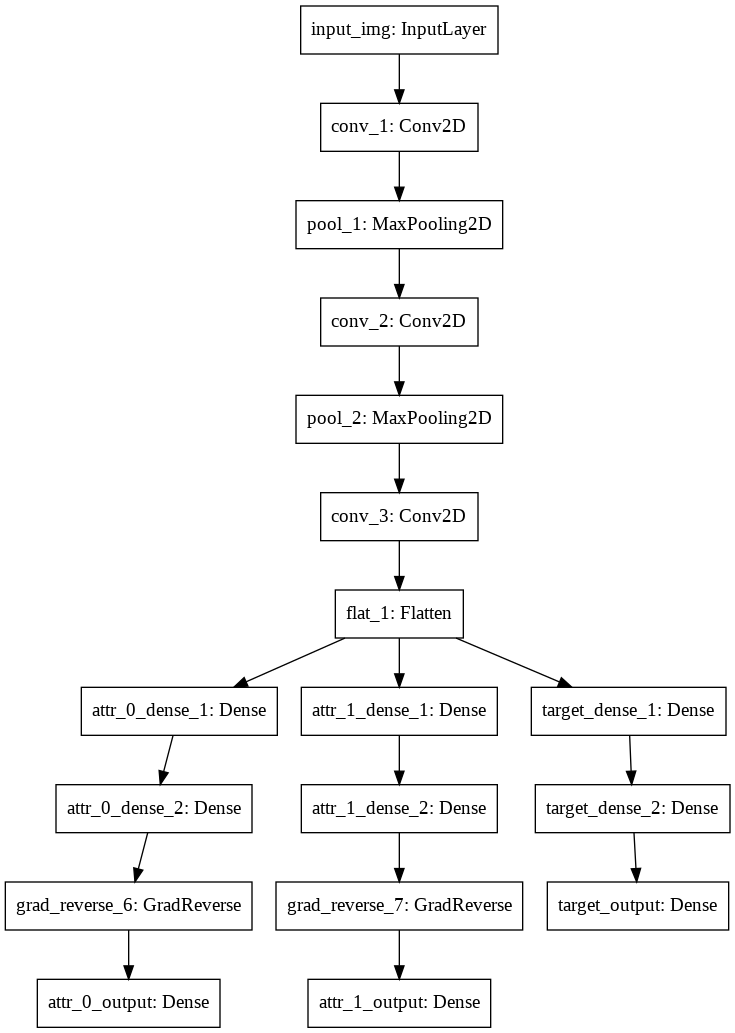

In [ ]:
# Model parameters
n_attributes = 2
target_loss_weight = 1.
attr_loss_weight = 1. 
    
# Input
model_input = Input(shape=(360, 360, 3), name="input_img")

# Feature extractor
x = Conv2D(32, (3, 3), padding = "same", activation = "relu", name = "conv_1")(model_input)
x = MaxPool2D(pool_size = (2, 2), name = "pool_1")(x)
x = Conv2D(64, (3, 3), padding = "same", activation = "relu", name = "conv_2")(x)
x = MaxPool2D(pool_size = (2, 2), name = "pool_2")(x)
x = Conv2D(64, (3, 3), padding = "same", activation = "relu", name = "conv_3")(x)
x = Flatten(name = "flat_1")(x)

# Target branch
x_target = Dense(100, activation="relu", name = "target_dense_1")(x)
x_target = Dense(20, activation="relu", name = "target_dense_2")(x_target)
target_output = Dense(1, name = "target_output")(x_target)
model_outputs = [target_output]   

# Create losses, weights and metrics
losses = {"target_output": tf.keras.losses.MeanSquaredError()}
target_metric = "mean_squared_error"
weights = {"target_output": target_loss_weight}
metrics = {"target_output": target_metric}    

# Split attribute loss across branches
attr_branch_weight = attr_loss_weight / n_attributes    

# Attribute branches
for i in range(n_attributes):  
  # Funnel into sigmoid for binary classification of attributes
  x_attr = Dense(100, activation="relu", name = "attr_{}_dense_1".format(i))(x)
  x_attr = Dense(20, activation="relu", name = "attr_{}_dense_2".format(i))(x_attr)
  # Gradient reversal layer
  x_attr = GradReverse()(x_attr)
  # Sigmoid output
  output_name = "attr_{}_output".format(i)
  attr_output = Dense(1, activation = "sigmoid", name = output_name)(x_attr) 
  # Add to outputs
  model_outputs.append(attr_output)
  # Add to losses, weights and metrics
  losses[output_name] = tf.keras.losses.BinaryCrossentropy()
  weights[output_name] = attr_branch_weight
  metrics[output_name] = "accuracy"   
    
# Make model
grad_model = tf.keras.Model(inputs = model_input, outputs = model_outputs, name = "GRAD_CNN")

# Compile model
grad_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = losses, loss_weights = weights, metrics = metrics)

# Plot model
plot_model(grad_model)

## Experiment: Model Selection

### Training Loop

### Results